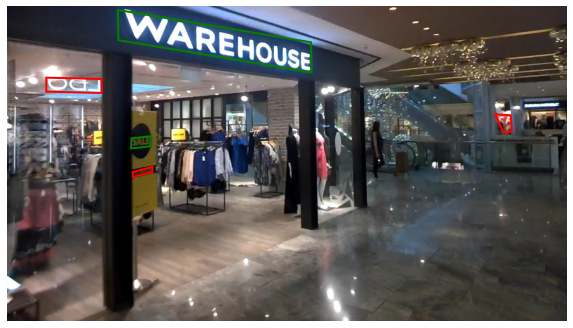

In [4]:
####################################################################################################################################################
## LIBRARIES:
import os
import glob
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.backends.backend_pdf import PdfPages
####################################################################################################################################################
## DISPLAY FUNCTIONS:

# Function Displayed 1: Represents the image together with the regenerated bounding boxes
def img_and_annotations(im, boxes, labels, save_flag):
    
    # The size of the figure is calculated to maintain the aspect ratio:
    fig_size = (8.3, 8.3*(im.shape[0]/im.shape[1]))
    
    # NOTE : A4 is [210mm X 297mm] or [8.3in X 11.7in] (W x H). To maintain the aspect ratio you
    # you must adjust the height to the dimensions of the images to be displayed.
    
    # The figure and the axis of representation are created:
    fig, ax = plt.subplots(figsize=fig_size)
    
    # The image is represented together with its annotations:
    ax.imshow(im.astype(np.uint8))
    for BB, label in zip(boxes, labels):
        if label:
            polygon = Polygon(BB, linewidth=2, edgecolor="r", facecolor="none") #Label not detected
        else:
            polygon = Polygon(BB, linewidth=2, edgecolor="g", facecolor="none") #Label detected
        ax.add_patch(polygon)
        
    # The axis is overridden and automatically adjusted:
    ax.axis("off")
    plt.tight_layout()
        
    # The image is saved as a high-resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("INTRO_image_and_anns.pdf") #PDF creation
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close() #PDF is closed
    return plt.gcf()
####################################################################################################################################################
## FUNCTIONS:

# Function 1: Loads the absolute path of images and annotations
def load_images_path(imgs_path, anns_path):

    # Initialise the list that will list all absolute paths of images and annotations:
    all_img_files = [] #Pictures -> In general ".jpg"
    all_ann_files = [] #Annotations -> ".txt"

    # Each of the image extensions is traversed and the complete list of images is output:
    for ext in ["jpeg", "jpg", "png"]:
        all_img_files.extend(glob.glob(os.path.join(imgs_path, "*.{}".format(ext))))

    # The full list of notations is extracted:
    all_ann_files.extend(glob.glob(os.path.join(anns_path, "*.txt")))

    # Both lists are sorted by image id/annotation number of the path of both:
    all_img_files = sorted(all_img_files.copy(), key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    all_ann_files = sorted(all_ann_files.copy(), key=lambda x: int(os.path.basename(x).split('_')[2].split('.')[0]))

    # A list is initialised that will list the image/notation pairs:
    all_pair_files = []

    # We go through each of the image paths and look for the annotation attached to it:
    for file in all_img_files:

        # The name of the attached annotation file is generated from the image:
        pair_ann_file = os.path.join(anns_path, "gt_" + os.path.basename(file).split(".")[0] + ".txt")

        # The pair is checked and if so, the pair is generated, if not, it is discarded:
        if pair_ann_file in all_ann_files:
            all_pair_files.append([file, pair_ann_file])

    # The process is terminated by passing the list of pairs as an array:
    return np.array(all_pair_files)

# Function 2: Load image with annotations
def load_images_with_annotations(pair_path):

    # Internal Function 1: Read the TXT according to the absolute path of the annotations
    def load_annotations(ann_path):

        # Initializes the lists where the vertices of the Bounding Box and its label will go:
        BB_list = []
        label = []

        # The file is opened, passed through the CSV reader and analysed line by line:
        with open(ann_path, "r") as file_opener:
            reader = csv.reader(file_opener)
            for line in reader:

                # Each line is stripped of BOMs and segmented into elements:
                line = [word.strip("\ufeff").strip("\xef\xbb\xbf") for word in line]

                # If the number of elements is greater than 9, the remaining elements are removed:
                if len(line) > 9:
                    line = line[:9]

                # The coordinates of the 4 corners of the "Bounding Box" are exported and stored:
                x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
                BB_list.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

                # The "label" (last element) is extended and filtered according to whether it is identified or not:
                if line[-1] == "###":
                     label.append(True)
                else:
                    label.append(False)

        # The extracted annotations are returned in array format:
        return np.array(BB_list, dtype=np.float32), np.array(label, dtype=np.bool_)

    # Internal Function 2: Correction of annotations to the original image dimensions
    def correct_annotations(orig_im, orig_ann, orig_label):

        # The dimensions of the original image are taken out:
        height, width, _ = orig_im.shape

        # Validate that the coordinates (x,y) are inside the image (width x height):
        orig_ann[:, :, 0] = np.clip(orig_ann[:, :, 0], 0, width - 1) #X
        orig_ann[:, :, 1] = np.clip(orig_ann[:, :, 1], 0, height - 1) #Y

        # The area of the polygon resulting from each of the annotations is calculated:
        area = np.sum([(orig_ann[:, 1, 0] - orig_ann[:, 0, 0]) * (orig_ann[:, 1, 1] + orig_ann[:, 0, 1]),
                       (orig_ann[:, 2, 0] - orig_ann[:, 1, 0]) * (orig_ann[:, 2, 1] + orig_ann[:, 1, 1]),
                       (orig_ann[:, 3, 0] - orig_ann[:, 2, 0]) * (orig_ann[:, 3, 1] + orig_ann[:, 2, 1]),
                       (orig_ann[:, 0, 0] - orig_ann[:, 3, 0]) * (orig_ann[:, 0, 1] + orig_ann[:, 3, 1])], axis=0)/2.0

        # The annotations are analysed one by one to modify the annotation and its label:
        for ii in range(len(area)):

            # Eliminate those annotations/labels with small area:
            if abs(area[ii]) < 1:
                orig_ann = np.delete(orig_ann, ii, axis=0)
                orig_label = np.delete(orig_label, ii, axis=0)

            # Orientation is changed to clockwise if area is positive:
            if area[ii] > 0:
                orig_ann[ii, :, :] = orig_ann[ii, (0, 3, 2, 1), :]

        # Corrected annotations are returned to original dimensions:
        return orig_ann, orig_label

    # (MAIN START) The image and the annotations contained in the attached txt are read:
    img = cv2.imread(pair_path[0])[:, :, ::-1] #BRG -> RGB
    ann_xy, ann_label = load_annotations(pair_path[1])

    # NOTE : As the image has been read with cv2, it returns the image in BGR, but in reality
    # should be displayed as RGB. As for the structure of the annotations, it is a vector dimesniones
    # (X,Y,Z), where X is the number of distinct annotations (each "Bounding Box"), Y is each of the vertices
    # defining a "Bounding Box" (there are 4) and Z is whether the x-coordinate (0) or y-coordinate (1) of the vertex

    # Annotations are corrected to the original dimensions of the image:
    ann_xy, ann_label = correct_annotations(img, ann_xy, ann_label)
    
    # Return the image with annotations and labels:
    return img, ann_xy, ann_label
####################################################################################################################################################
## MAIN: Allows you to view a random image with its annotation.

## "Dataset" change flag is initialised: True-> Training // False -> Validation
dataset_flag = False

# Get the working directory and generate the data path:
work_path = os.getcwd()
train_im_path = os.path.join(work_path, "Scene_Text_Datasets", "Training_Images")
train_ann_path = os.path.join(work_path, "Scene_Text_Datasets", "Training_Annotations")
val_im_path = os.path.join(work_path, "Scene_Text_Datasets", "Validation_Images")
val_ann_path = os.path.join(work_path, "Scene_Text_Datasets", "Validation_Annotations")

# Decide which data path to extract based on the flag:
if dataset_flag:
    img_path = train_im_path
    ann_path = train_ann_path
else:
    img_path = val_im_path
    ann_path = val_ann_path

# All absolute image paths are loaded (randomly selected 1):
all_files = load_images_path(train_im_path, train_ann_path)
idx_selected = np.random.randint(all_files.shape[0])
all_files = all_files[idx_selected] #Good example is idx_selected = 58

# The image is output with its annotations and labels:
image, boxes, labels = load_images_with_annotations(all_files)

# Render image and annotations:
fig1 = img_and_annotations(image, boxes, labels, False)
plt.show()

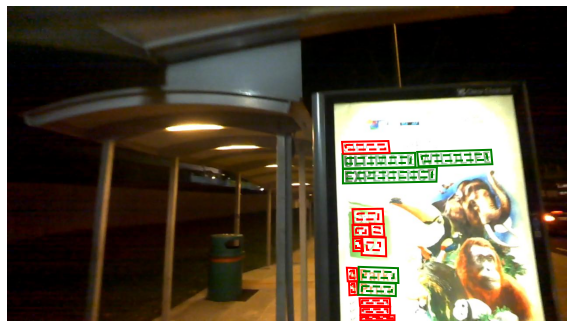

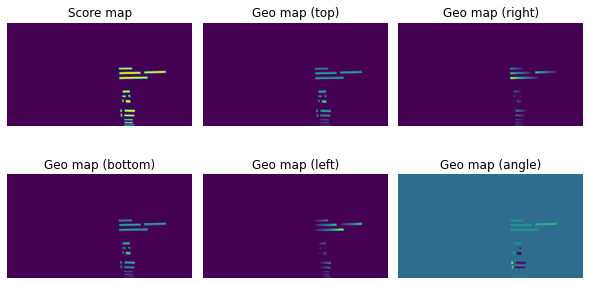

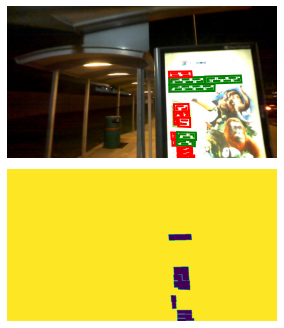

In [5]:
####################################################################################################################################################
## LIBRARIES:
import os
import glob
import cv2
import csv
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon
from matplotlib.backends.backend_pdf import PdfPages
####################################################################################################################################################
## DISPLAY FUNCTIONS:

## function Display 1: Renders the image together with the regenerated and shrunk bounding boxes
def img_and_annotations(im, boxes, shrink_boxes, labels, save_flag):
    
    # The size of the figure is calculated to maintain the aspect ratio:
    fig_size = (8.3, 8.3*(im.shape[0]/im.shape[1]))
    
    # NOTE : An A4 is [210mm X 297mm] or [8.3in X 11.7in] (W X H). To maintain the aspect ratio you
    # you must adjust the height to the dimensions of the images to be represented.
    
    # The figure and the rendering axis are created:
    fig, ax = plt.subplots(figsize=fig_size)
    
    # The image is rendered along with the annotations (large and small) of the image:
    ax.imshow(im.astype(np.uint8))
    for BB, shk_BB, label in zip(boxes, shrink_boxes, labels):
        if label:
            polygon1 = Polygon(BB, linewidth=2, edgecolor="r", facecolor="none") #Label not detected
            polygon2 = Polygon(shk_BB, linewidth=2, linestyle="--", edgecolor="r", facecolor="none") #Label not detected
        else:
            polygon1 = Polygon(BB, linewidth=2, edgecolor="g", facecolor="none") #Label detected
            polygon2 = Polygon(shk_BB, linewidth=2, linestyle="--", edgecolor="g", facecolor="none") #Label detected
        ax.add_patch(polygon1)
        ax.add_patch(polygon2)
        
    # Axis is overridden and automatically adjusted:
    ax.axis("off")
    plt.tight_layout()
        
    # Save the image as a high resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("DATASET_image_and_anns.pdf") #PDF creation
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close() #PDF is closed
    return plt.gcf()

# Visualization function 2: Renders score and geometric maps
def maps_visualization(score_map, geo_maps, save_flag):
    
    # Title text is initialized:
    titles = ["Score map", "Geo map (top)", "Geo map (right)", "Geo map (bottom)", "Geo map (left)", "Geo map (angle)"]
    
    # Representation maps are merged:
    all_maps = np.dstack((score_map, geo_maps))
    
    # Calculate the size of the figure to maintain the aspect ratio:
    fig_size = (8.3, 8.3*(all_maps.shape[0]/all_maps.shape[1]))
    
    # NOTE : An A4 is [210mm X 297mm] or [8.3in X 11.7in] (W X H). To maintain the aspect ratio you
    # you must adjust the height to the dimensions of the images to be represented.
    
    # The figure and the rendering axes are created:
    fig, axs = plt.subplots(2, 3, figsize=fig_size)
    
    # Traverse each axis to represent the map, assigning and overriding the axes:
    for idx, ax in enumerate(axs.flat):
        ax.imshow(all_maps[:, :, idx])
        ax.set_title(titles[idx], fontsize=12)
        ax.axis("off")
        
    # Set automatically:
    plt.tight_layout()
        
    # Image is saved as a high resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("DATASET_image_maps.pdf") #PDF creation
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close() #PDF is closed
    return plt.gcf()

# Function Displayed 3: Represents the image together with the regenerated and shrunk bounding boxes and the mask
def img_and_annotations_with_mask(im, boxes, shrink_boxes, labels, train_mask, save_flag):
    
    # The size of the figure is calculated to maintain the aspect ratio:
    fig_size = (8.3, 8.3*(im.shape[0]/im.shape[1]))
    
    # NOTE : An A4 is [210mm X 297mm] or [8.3in X 11.7in] (W X H). To maintain the aspect ratio you
    # you must adjust the height to the dimensions of the images to be represented.
    
    # The figure and the rendering axes are created:
    fig, axs = plt.subplots(2, 1, figsize=fig_size)
    
    # The image is rendered together with its annotations (large and small) (first axis):
    axs[0].imshow(im.astype(np.uint8))
    for BB, shk_BB, label in zip(boxes, shrink_boxes, labels):
        if label:
            polygon1 = Polygon(BB, linewidth=2, edgecolor="r", facecolor="none") #Label not detected
            polygon2 = Polygon(shk_BB, linewidth=2, linestyle="--", edgecolor="r", facecolor="none") #Label not detected
        else:
            polygon1 = Polygon(BB, linewidth=2, edgecolor="g", facecolor="none") #Label detected.
            polygon2 = Polygon(shk_BB, linewidth=2, linestyle="--", edgecolor="g", facecolor="none") #Label detected
        axs[0].add_patch(polygon1)
        axs[0].add_patch(polygon2)
    axs[0].axis("off") #The axis is canceled
    
    # The training mask (second axis) is represented:
    axs[1].imshow(train_mask)
    axs[1].axis("off") #The axis is canceled
        
    # Automatically set:
    plt.tight_layout()
        
    # Save the image as a high resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("DATASET_image_and_anns_and_mask.pdf") #PDF creation
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close() #PDF is closed
    return plt.gcf()
####################################################################################################################################################
## FUNCTIONS:

## Function 1: Load the absolute paths of images and annotations
def load_images_path(imgs_path, anns_path):

    # Initialize the list that will load all absolute paths of images and annotations:
    all_img_files = [] #Images -> In general ".jpg"
    all_ann_files = [] #Annotations -> ".txt"

    # Each of the image extensions is traversed and the complete list of images is output:
    for ext in ["jpeg", "jpg", "png"]:
        all_img_files.extend(glob.glob(os.path.join(imgs_path, "*.{}".format(ext))))

    # The full list of notations is extracted:
    all_ann_files.extend(glob.glob(os.path.join(anns_path, "*.txt")))

    # Both lists are sorted by image id/annotation number of the path of both:
    all_img_files = sorted(all_img_files.copy(), key=lambda x: int(os.path.basename(x).split('_')[1].split('.')[0]))
    all_ann_files = sorted(all_ann_files.copy(), key=lambda x: int(os.path.basename(x).split('_')[2].split('.')[0]))

    # A list is initialised that will list the image/notation pairs:
    all_pair_files = []

    # We go through each of the image paths and look for the annotation attached to it:
    for file in all_img_files:

        # The name of the attached annotation file is generated from the image:
        pair_ann_file = os.path.join(anns_path, "gt_" + os.path.basename(file).split(".")[0] + ".txt")

        # The pair is checked and if so, the pair is generated, if not, it is discarded:
        if pair_ann_file in all_ann_files:
            all_pair_files.append([file, pair_ann_file])

    # The process is terminated by passing the list of pairs as an array:
    return np.array(all_pair_files)

# Function 2: Load image with annotations
def load_images_with_annotations(pair_path):

    # Internal Function 1: Read the TXT according to the absolute path of the annotations
    def load_annotations(ann_path):

        # The lists where the vertices of the "Bounding Box" and its "label" will go are initialised:
        BB_list = []
        label = []

        # Open the file, pass it through the CSV reader and analyse it line by line:
        with open(ann_path, "r") as file_opener:
            reader = csv.reader(file_opener)
            for line in reader:

                # Each line is stripped of BOMs and segmented into elements:
                line = [word.strip("\ufeff").strip("\xef\xbb\xbf") for word in line]

                # If the number of elements is greater than 9, the remaining elements are removed:
                if len(line) > 9:
                    line = line[:9]

                # The coordinates of the 4 corners of the "Bounding Box" are exported and stored:
                x1, y1, x2, y2, x3, y3, x4, y4 = list(map(float, line[:8]))
                BB_list.append([[x1, y1], [x2, y2], [x3, y3], [x4, y4]])

                # The "label" (last element) is extended and filtered according to whether it is identified or not:
                if line[-1] == "###":
                     label.append(True)
                else:
                    label.append(False)

        # The extracted annotations are returned in "array" format:
        return np.array(BB_list, dtype=np.float32), np.array(label, dtype=np.bool_)

    # Internal Function 2: Correction of annotations to the original dimensions of the image
    def correct_annotations(orig_im, orig_ann, orig_label):

        # The dimensions of the original image are taken out:
        height, width, _ = orig_im.shape

        # Validate that the coordinates (x,y) are inside the image (width x height):
        orig_ann[:, :, 0] = np.clip(orig_ann[:, :, 0], 0, width - 1) #X
        orig_ann[:, :, 1] = np.clip(orig_ann[:, :, 1], 0, height - 1) #Y

        # The area of the polygon resulting from each of the annotations is calculated:
        area = np.sum([(orig_ann[:, 1, 0] - orig_ann[:, 0, 0]) * (orig_ann[:, 1, 1] + orig_ann[:, 0, 1]),
                       (orig_ann[:, 2, 0] - orig_ann[:, 1, 0]) * (orig_ann[:, 2, 1] + orig_ann[:, 1, 1]),
                       (orig_ann[:, 3, 0] - orig_ann[:, 2, 0]) * (orig_ann[:, 3, 1] + orig_ann[:, 2, 1]),
                       (orig_ann[:, 0, 0] - orig_ann[:, 3, 0]) * (orig_ann[:, 0, 1] + orig_ann[:, 3, 1])], axis=0)/2.0

        # The annotations are analysed one by one to modify the annotation and its label:
        for ii in range(len(area)):

            # Eliminates those annotations/labels with small area:
            if abs(area[ii]) < 1:
                orig_ann = np.delete(orig_ann, ii, axis=0)
                orig_label = np.delete(orig_label, ii, axis=0)

            # Orientation is changed to clockwise if area is positive:
            if area[ii] > 0:
                orig_ann[ii, :, :] = orig_ann[ii, (0, 3, 2, 1), :]

        # Corrected annotations are returned to original dimensions:
        return orig_ann, orig_label

    # (MAIN START) The image and the annotations contained in the attached txt are read:
    img = cv2.imread(pair_path[0])[:, :, ::-1] #BRG -> RGB
    ann_xy, ann_label = load_annotations(pair_path[1])

    # NOTE : As the image has been read with cv2, it returns the image in BGR, but in reality
    # should be displayed as RGB. As for the structure of the annotations, it is a vector dimesniones
    # (X,Y,Z), where X is the number of distinct naotations (each "Bounding Box"), Y is each of the vertices 
    # defining a "Bounding Box" (there are 4) and Z is whether the x-coordinate (0) or y-coordinate (1) of the vertex
    
    # Annotations are corrected to the original dimensions of the image:
    ann_xy, ann_label = correct_annotations(img, ann_xy, ann_label)
    
    # Return the image with annotations and labels:
    return img, ann_xy, ann_label

# Function 3: Generate the score, geometric and mask maps:
def maps_generator(img, anns, labels):

    # Internal Function 1: In charge of "shrinking" the "Bounding Box" defined in the annotations
    def poly_shrinker(poly, r):

        # PARAMETERS:
        # poly -> Vertices of annotations [x1,y1], [x2,y2], [x3,y3] and [x4,y4]
        # r -> Ratio in the original rescaled image
        # return -> Vertices adjusted to the rescaled image
        R = 0.3 #shrink ratio

        # Find the longer pair
        if np.linalg.norm(poly[0] - poly[1]) + np.linalg.norm(poly[2] - poly[3]) > np.linalg.norm(poly[0] - poly[3]) + np.linalg.norm(poly[1] - poly[2]):
            # First move (p0, p1), (p2, p3), then (p0, p3), (p1, p2)
            ## p0, p1
            theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
            poly[0][0] += R * r[0] * np.cos(theta)
            poly[0][1] += R * r[0] * np.sin(theta)
            poly[1][0] -= R * r[1] * np.cos(theta)
            poly[1][1] -= R * r[1] * np.sin(theta)
            ## p2, p3
            theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
            poly[3][0] += R * r[3] * np.cos(theta)
            poly[3][1] += R * r[3] * np.sin(theta)
            poly[2][0] -= R * r[2] * np.cos(theta)
            poly[2][1] -= R * r[2] * np.sin(theta)
            ## p0, p3
            theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
            poly[0][0] += R * r[0] * np.sin(theta)
            poly[0][1] += R * r[0] * np.cos(theta)
            poly[3][0] -= R * r[3] * np.sin(theta)
            poly[3][1] -= R * r[3] * np.cos(theta)
            ## p1, p2
            theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
            poly[1][0] += R * r[1] * np.sin(theta)
            poly[1][1] += R * r[1] * np.cos(theta)
            poly[2][0] -= R * r[2] * np.sin(theta)
            poly[2][1] -= R * r[2] * np.cos(theta)
        else:
            ## p0, p3
            theta = np.arctan2((poly[3][0] - poly[0][0]), (poly[3][1] - poly[0][1]))
            poly[0][0] += R * r[0] * np.sin(theta)
            poly[0][1] += R * r[0] * np.cos(theta)
            poly[3][0] -= R * r[3] * np.sin(theta)
            poly[3][1] -= R * r[3] * np.cos(theta)
            ## p1, p2
            theta = np.arctan2((poly[2][0] - poly[1][0]), (poly[2][1] - poly[1][1]))
            poly[1][0] += R * r[1] * np.sin(theta)
            poly[1][1] += R * r[1] * np.cos(theta)
            poly[2][0] -= R * r[2] * np.sin(theta)
            poly[2][1] -= R * r[2] * np.cos(theta)
            ## p0, p1
            theta = np.arctan2((poly[1][1] - poly[0][1]), (poly[1][0] - poly[0][0]))
            poly[0][0] += R * r[0] * np.cos(theta)
            poly[0][1] += R * r[0] * np.sin(theta)
            poly[1][0] -= R * r[1] * np.cos(theta)
            poly[1][1] -= R * r[1] * np.sin(theta)
            ## p2, p3
            theta = np.arctan2((poly[2][1] - poly[3][1]), (poly[2][0] - poly[3][0]))
            poly[3][0] += R * r[3] * np.cos(theta)
            poly[3][1] += R * r[3] * np.sin(theta)
            poly[2][0] -= R * r[2] * np.cos(theta)
            poly[2][1] -= R * r[2] * np.sin(theta)
        return poly

    # Internal Function 2: Find the coordinates of the 4 vertices given by poly (scanned clockwise)
    def sort_rectangle(poly):

        # First find the lowest point
        p_lowest = np.argmax(poly[:, 1])

        # If the bottom line is parallel to x-axis, then p0 must be the upper-left corner
        if np.count_nonzero(poly[:, 1] == poly[p_lowest, 1]) == 2:
            p0_index = np.argmin(np.sum(poly, axis=1))
            p1_index = (p0_index + 1) % 4
            p2_index = (p0_index + 2) % 4
            p3_index = (p0_index + 3) % 4
            return poly[[p0_index, p1_index, p2_index, p3_index]], 0.0
        else:

            # Find the point that sits right to the lowest point
            p_lowest_right = (p_lowest - 1) % 4
            p_lowest_left = (p_lowest + 1) % 4
            angle = np.arctan(-(poly[p_lowest][1] - poly[p_lowest_right][1])/(poly[p_lowest][0] - poly[p_lowest_right][0]))

            # This point is p2
            if angle / np.pi * 180 > 45:
                p2_index = p_lowest
                p1_index = (p2_index - 1) % 4
                p0_index = (p2_index - 2) % 4
                p3_index = (p2_index + 1) % 4
                return poly[[p0_index, p1_index, p2_index, p3_index]], -(np.pi/2 - angle)

            # This point is p3
            else:
                p3_index = p_lowest
                p0_index = (p3_index + 1) % 4
                p1_index = (p3_index + 2) % 4
                p2_index = (p3_index + 3) % 4
                return poly[[p0_index, p1_index, p2_index, p3_index]], angle
            
    # (MAIN BEGIN) The dimensions of the input image are taken:
    height, width, _ = img.shape

    # The maps and masks to be generated are initialized according to the dimensions provided:
    shrink_anns = np.array([]).reshape((0, 4, 2))
    score_map = np.zeros((height, width), dtype=np.uint8) #(height, width)
    geo_map = np.zeros((height, width, 5), dtype=np.float32) #(height, width)
    vert_mask = np.zeros((height, width), dtype=np.uint8) #(height, width)
    training_mask = np.ones((height, width), dtype=np.uint8) #(height, width)

    # Each row of annotations and labels is traversed:
    for idx, ann_and_label in enumerate(zip(anns, labels)):

        # The ratio vector is initialized and the annotation/"label" is displayed:
        rat = [None, None, None, None]
        BB = ann_and_label[0]
        label = ann_and_label[1]

        # The smallest of the norms/ratios is calculated and the "poly_shrinker" is applied:
        for ii in range(len(rat)):
            rat[ii] = min(np.linalg.norm(BB[ii] - BB[(ii+1)%4]), np.linalg.norm(BB[ii] - BB[(ii-1)%4]))
        shrink_vert = poly_shrinker(BB.copy(), rat).astype(np.int32)[np.newaxis, :, :]
        
        # The reduced polygon is saved:
        shrink_anns = np.append(shrink_anns, [shrink_vert[0]], axis=0)
        
        # The score map and the mask of the vertices are generated:
        cv2.fillPoly(score_map, shrink_vert, 1)
        cv2.fillPoly(vert_mask, shrink_vert, idx + 1)

        # The minimum of the width and height of the polynomial that defines the vertices is calculated:
        vert_h = min(np.linalg.norm(BB[0] - BB[3]), np.linalg.norm(BB[1] - BB[2]))
        vert_w = min(np.linalg.norm(BB[0] - BB[1]), np.linalg.norm(BB[2] - BB[3]))

        # Those polynomials that do not reach the font size and have a label with text are ignored:
        if (min(vert_h, vert_w) < 10) or label:
            cv2.fillPoly(training_mask, BB.astype(np.int32)[np.newaxis, :, :], 0)

        # The (x,y) is identified within the mask of vertices, positions in the matrix:
        xy_mask = np.argwhere(vert_mask == (idx + 1))

        # The minimum contained area is sought and the vertices that generate it are sought:
        min_box = cv2.minAreaRect(BB)
        (p0_rect, p1_rect, p2_rect, p3_rect), angle = sort_rectangle(cv2.boxPoints(min_box))

        # NOTE: The original vertices suppose a box that surrounds an area, which depending
        # of your orientation should be minimal. The four corners are located in that minimum area,
        # through the analysis of that area: center, (w, h) and angle. Since the function "cv2.boxPoints(box)"
        # returns: p0_rect, p1_rect, p2_rect and p3_rect.

        # The (x,y) of the vertices are iterated to obtain the geometric maps:
        for y, x in xy_mask:
            point = np.array([x, y], dtype=np.float32)
            geo_map[y, x, 0] = np.linalg.norm(np.cross(p1_rect - p0_rect, p0_rect - point))/np.linalg.norm(p1_rect - p0_rect) #Top
            geo_map[y, x, 1] = np.linalg.norm(np.cross(p2_rect - p1_rect, p1_rect - point))/np.linalg.norm(p2_rect - p1_rect) #Right
            geo_map[y, x, 2] = np.linalg.norm(np.cross(p3_rect - p2_rect, p2_rect - point))/np.linalg.norm(p3_rect - p2_rect) #Bottom
            geo_map[y, x, 3] = np.linalg.norm(np.cross(p0_rect - p3_rect, p3_rect - point))/np.linalg.norm(p0_rect - p3_rect) #Left
            geo_map[y, x, 4] = angle #Angle

    # Maps are delivered:
    return shrink_anns, score_map, geo_map, training_mask
####################################################################################################################################################
## MAIN: Allows you to view a random image with its annotation and maps

# The "Dataset" change flag is initialized: True-> Training // False -> Validation:
dataset_flag = False

# Obtaining the working directory and generating the data path:
work_path = os.getcwd()
train_im_path = os.path.join(work_path, "Scene_Text_Datasets", "Training_Images")
train_ann_path = os.path.join(work_path, "Scene_Text_Datasets", "Training_Annotations")
val_im_path = os.path.join(work_path, "Scene_Text_Datasets", "Validation_Images")
val_ann_path = os.path.join(work_path, "Scene_Text_Datasets", "Validation_Annotations")

# It is decided which "path" of data to extract according to the "flag":
if dataset_flag:
    img_path = train_im_path
    ann_path = train_ann_path
else:
    img_path = val_im_path
    ann_path = val_ann_path

# All absolute paths of the images are loaded (randomly selected 1):
all_files = load_images_path(train_im_path, train_ann_path)
idx_selected = np.random.randint(all_files.shape[0])
all_files = all_files[idx_selected] #Good example is idx_selected = 322

# The image is taken with its annotations and labels:
image, boxes, labels = load_images_with_annotations(all_files)

# The RBOX maps of the selected image are output:
shrink_boxes, score_map, geo_maps, training_mask = maps_generator(image, boxes, labels)

########################
##### Save flag ########
#save = True ###########
save = False ###########
########################

# The image, annotations and shrunken annotations are rendered:
fig1 = img_and_annotations(image, boxes, shrink_boxes, labels, save)
plt.show()

# Maps are represented:
fig2 = maps_visualization(score_map, geo_maps, save)
plt.show()

# The image, annotations and shrunken annotations are rendered:
fig3 = img_and_annotations_with_mask(image, boxes, shrink_boxes, labels, training_mask, save)
plt.show()

The NMS algorithm has taken 3676.509141921997 mseg.
In total there are 5453 boxes, but in reality they are 26.


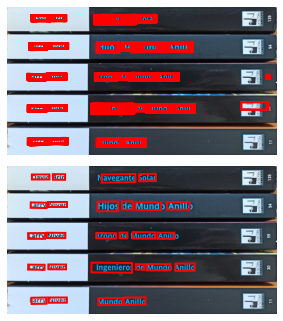

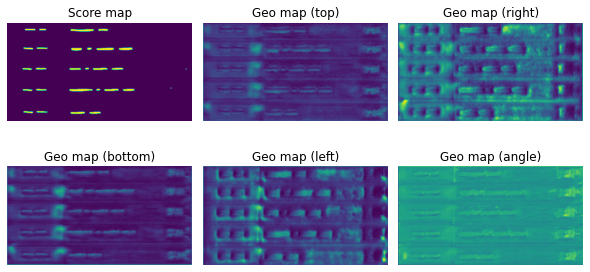

In [6]:
####################################################################################################################################################
## LIBRARIES:
import os
import cv2
import time
import numpy as np
import shapely as shap
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from matplotlib.patches import Polygon
from matplotlib.backends.backend_pdf import PdfPages
####################################################################################################################################################
## DISPLAY FUNCTIONS:

# Function Displayed 1: Represents the image along with the regenerated and filtered "bounding boxes"
def img_and_annotations(im, all_boxes, filter_boxes, save_flag):
    
    # The size of the figure is calculated to maintain the "aspect ratio":
    fig_size = (8.3, 8.3*(im.shape[0]/im.shape[1]))
    
    # NOTE : An A4 is [210mm X 297mm] or [8.3in X 11.7in] (Width X Height). To maintain the "aspect ratio"
    # you must adjust the height to the dimensions of the images to be represented.
    
    # The figure and representation axes are created:
    fig, axs = plt.subplots(2, 1, figsize=fig_size)
    
    # The image is represented along with its unfiltered annotations (first axis):
    axs[0].imshow(im.astype(np.uint8))
    for BB in all_boxes:
        polygon = Polygon(BB, linewidth=2, edgecolor="r", facecolor="none")
        axs[0].add_patch(polygon)
    axs[0].axis("off") #The axis is canceled
    
    # The image is represented along with its unfiltered annotations (second axis):
    axs[1].imshow(im.astype(np.uint8))
    for BB in filter_boxes:
        polygon = Polygon(BB, linewidth=2, edgecolor="r", facecolor="none")
        axs[1].add_patch(polygon)
    axs[1].axis("off") #The axis is canceled
        
    # Adjusts automatically:
    plt.tight_layout()
        
    # The image is saved as a high resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("REAL_image_preNMS_and_posNMS.pdf") #PDF Creation
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close() #PDF closes
    return plt.gcf()

# Displayed Function 2: Represents the score and geometric maps
def maps_visualization(score_map, geo_maps, save_flag):
    
    # The title text is initialized:
    titles = ["Score map", "Geo map (top)", "Geo map (right)", "Geo map (bottom)", "Geo map (left)", "Geo map (angle)"]
    
    # Representation maps are merged:
    all_maps = np.dstack((score_map, geo_maps))
    
    # The size of the figure is calculated to maintain the "aspect ratio":
    fig_size = (8.3, 8.3*(all_maps.shape[0]/all_maps.shape[1]))
    
    # NOTE : An A4 is [210mm X 297mm] or [8.3in X 11.7in] (Width X Height). To maintain the "aspect ratio"
    # you must adjust the height to the dimensions of the images to be represented.
    
    # The figure and the representation axis are created:
    fig, axs = plt.subplots(2, 3, figsize=fig_size)
    
    # Each axis is traversed to represent the map by assigning and canceling the axes:
    for idx, ax in enumerate(axs.flat):
        ax.imshow(all_maps[:, :, idx])
        ax.set_title(titles[idx], fontsize=12)
        ax.axis("off")
        
    # Adjusts automatically:
    plt.tight_layout()
        
    # The image is saved as a high resolution PDF:
    if save_flag:
        pdf_pages = PdfPages("REAL_image_maps.pdf") #PDF Creation
        pdf_pages.savefig(fig, bbox_inches="tight", dpi=600)
        pdf_pages.close() #PDF closes
    return plt.gcf()
####################################################################################################################################################
## FUNCTIONS:

# Function 1: Load the path image, scale it and make the prediction
def Text_Detection(EAST_path, img_path):
    
    # Internal Function 1: Responsible for generating the EASTlite model
    def EASTlite():

        # Load the input layer along with the input preprocessing layer:
        input_ly = keras.Input(shape=[None, None, 3], dtype=tf.float32, name="Input_LY")
        input_ly = keras.applications.resnet.preprocess_input(input_ly)

        # The base model attached to the input layer is loaded and the list of layers is initialized:
        base_model = keras.applications.MobileNet(input_tensor=input_ly, include_top=False)
        base_model_layers = [] #Here only the layers to be used will be stored

        # All layers of the base model are traversed:
        for layer in base_model.layers:

            # The layer is allowed to be trained and those layers that are going to be used are stored:
            layer.trainable = True
            if layer.name in ["conv_pw_2_relu", "conv_pw_5_relu", "conv_pw_11_relu", "conv_pw_13_relu"]:
                base_model_layers.append(layer)

        # The EAST output flows are initialized:
        base_model_layers.reverse() #From bottom to top
        f = [layer.output for layer in base_model_layers] #Feature maps
        h = [None, None, None, None] #Merged feature map
        g = [None, None, None, None] #Merge base
        outputs_size = [None, 128, 64, 32]

        # Each of the states of both EAST blocks is traversed:
        for idx in range(len(f)):

            # In the case of 0, both outputs match (f1 = h1):
            if idx == 0:
                h[idx] = f[idx]

            # Otherwise "h" is defined as Conv3x3(Conv1x1(...)):
            else:
                conv_1x1 = keras.layers.Conv2D(filters=outputs_size[idx], kernel_size=1, activation="relu", padding="same",
                                               kernel_regularizer=keras.regularizers.L2(0.001))(tf.concat([g[idx - 1], f[idx]], axis=-1))
                h[idx] = keras.layers.Conv2D(filters=outputs_size[idx], kernel_size=3, activation="relu", padding="same",
                                             kernel_regularizer=keras.regularizers.L2(0.001))(conv_1x1)

            # Once the "merged feature map" is defined, the "base merge" is coupled to it:
            if idx <= 2:
                g[idx] = keras.layers.UpSampling2D(size=(2, 2), data_format="channels_last", interpolation="bilinear")(h[idx])
            else:
                g[idx] =  keras.layers.Conv2D(filters=outputs_size[idx], kernel_size=3, activation="relu", padding="same",
                                              kernel_regularizer=keras.regularizers.L2(0.001))(h[idx])

        # Once the model is completed, the output layer of the score, geometric and angle map is defined:
        score_map = keras.layers.Conv2D(filters=1, kernel_size=1, activation=tf.nn.sigmoid, padding="same",
                                        kernel_regularizer=keras.regularizers.L2(0.001))(g[3])
        geo_map = (keras.layers.Conv2D(filters=4, kernel_size=1, activation=tf.nn.sigmoid, padding="same",
                                       kernel_regularizer=keras.regularizers.L2(0.001))(g[3])*512)
        angle_map = ((keras.layers.Conv2D(filters=1, kernel_size=1, activation=tf.nn.sigmoid, padding="same",
                                          kernel_regularizer=keras.regularizers.L2(0.001))(g[3]) - 0.5)* np.pi/2)

        # The geometric map is put together with the angle map and the model output is prepared:
        complete_geo_map = tf.concat([geo_map, angle_map], axis=-1)
        output_ly = tf.concat([complete_geo_map, score_map], axis=-1)

        # The model is created and returned:
        model = keras.Model(inputs=input_ly, outputs=[output_ly], name="TFM_EAST")
        return model
    
    # (MAIN BEGIN) The image and its dimensions are loaded:
    img = cv2.imread(img_path)[:, :, ::-1] #BRG -> RGB
    height, width, _ = img.shape
    
    # The model and weights are loaded:
    EASTlite_model = EASTlite()
    EASTlite_model.load_weights(EAST_path)

    # The lateral limitation ratio is calculated according to the maximum admissible:
    if max(height, width) > 2400:
        ratio = (2400/height if height > width else 2400/width)
    else:
        ratio = 1.0

    # The sides are corrected so that they do not exceed the limitation ratio:
    height_rs = int(height*ratio)
    width_rs = int(width*ratio)

    # These dimensions are limited to multiples of 32 and the new dimensions are generated:
    height_rs = height_rs if height_rs % 32 == 0 else (height_rs // 32 - 1) * 32
    width_rs = width_rs if width_rs % 32 == 0 else (width_rs // 32 - 1) * 32
    height_rs = max(32, height_rs)
    width_rs = max(32, width_rs)

    # The image is scaled to the new dimensions, the prediction is made and the predicted maps are segmented:
    img_rs = cv2.resize(img.copy(), (int(width_rs), int(height_rs)))
    pred_maps = EASTlite_model.predict(img_rs[np.newaxis, :, :, :], batch_size=1)
    geo_maps = np.array(pred_maps[0, :, :, :5]) #Geometric map "Top-Right-Bottom-Left-Angle"
    score_map = np.array(pred_maps[0, :, :, 5]) #Score map
    
    # The normal image, ratios and maps are returned:
    return img, (height_rs/float(height), width_rs/float(width)), score_map, geo_maps

# Function 2: Generates the "bounding boxes" and filters them
def bounding_boxes_filter(score_map, geo_maps, rat):
    
    # Internal Function 1: Get the vertex vector through the score and geometric maps
    def restore_rectangle(orig, geomt):

        # The geometric map is extracted "Top-Right-Bottom-Left" and "angle":
        TRDL = geomt[:, :4]
        angle = geomt[:, 4]

        # Adapts for the case of angle greater than 0 (filtering):
        orig_0 = orig[angle >= 0]
        TRDL_0 = TRDL[angle >= 0]
        angle_0 = angle[angle >= 0]

        # If the angle is greater than 0, the following applies:
        if orig_0.shape[0] > 0:

            # The matrix that condenses the geometric structure of the box is generated:
            p = np.array([np.zeros(TRDL_0.shape[0]), -TRDL_0[:, 0] - TRDL_0[:, 2], TRDL_0[:, 1] + TRDL_0[:, 3],
                          -TRDL_0[:, 0] - TRDL_0[:, 2], TRDL_0[:, 1] + TRDL_0[:, 3], np.zeros(TRDL_0.shape[0]),
                          np.zeros(TRDL_0.shape[0]), np.zeros(TRDL_0.shape[0]), TRDL_0[:, 3], -TRDL_0[:, 2]])
            p = p.transpose((1, 0)).reshape((-1, 5, 2)) #-> N*5*2

            # The rotation matrices that must be applied to the box in the x and y axes are determined:
            rotate_matrix_x = np.array([np.cos(angle_0), np.sin(angle_0)]).transpose((1, 0))
            rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))  #-> N*5*2
            rotate_matrix_y = np.array([-np.sin(angle_0), np.cos(angle_0)]).transpose((1, 0))
            rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

            # The generated geometric matrix is rotated:
            p_rotate_x = np.sum(rotate_matrix_x*p, axis=2)[:, :, np.newaxis]  #-> N*5*1
            p_rotate_y = np.sum(rotate_matrix_y*p, axis=2)[:, :, np.newaxis]  #-> N*5*1
            p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  #-> N*5*2

            # The 4 vertices of the polygon are determined:
            p3_in_origin = orig_0 - p_rotate[:, 4, :]
            new_p0 = p_rotate[:, 0, :] + p3_in_origin  #-> N*2
            new_p1 = p_rotate[:, 1, :] + p3_in_origin
            new_p2 = p_rotate[:, 2, :] + p3_in_origin
            new_p3 = p_rotate[:, 3, :] + p3_in_origin
            new_p_0 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                      new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  #-> N*4*2
        else:
            new_p_0 = np.zeros((0, 4, 2)) #In case the angle is negative

        # In the case of a negative angle, the other point of the polygon is initialized:
        orig_1 = orig[angle < 0]
        TRDL_1 = TRDL[angle < 0]
        angle_1 = angle[angle < 0]

        # If the angle is less than 0, the following applies:
        if orig_1.shape[0] > 0:

            # The matrix that condenses the geometric structure of the box (now negative angle) is generated:
            p = np.array([-TRDL_1[:, 1] - TRDL_1[:, 3], -TRDL_1[:, 0] - TRDL_1[:, 2], np.zeros(TRDL_1.shape[0]),
                          -TRDL_1[:, 0] - TRDL_1[:, 2], np.zeros(TRDL_1.shape[0]), np.zeros(TRDL_1.shape[0]),
                          -TRDL_1[:, 1] - TRDL_1[:, 3], np.zeros(TRDL_1.shape[0]), -TRDL_1[:, 1], -TRDL_1[:, 2]])
            p = p.transpose((1, 0)).reshape((-1, 5, 2))  #-> N*5*2

            # The rotation matrices that must be applied to the box in the x and y axes (now negative angle) are determined:
            rotate_matrix_x = np.array([np.cos(-angle_1), -np.sin(-angle_1)]).transpose((1, 0))
            rotate_matrix_x = np.repeat(rotate_matrix_x, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1)) #-> N*5*2
            rotate_matrix_y = np.array([np.sin(-angle_1), np.cos(-angle_1)]).transpose((1, 0))
            rotate_matrix_y = np.repeat(rotate_matrix_y, 5, axis=1).reshape(-1, 2, 5).transpose((0, 2, 1))

            # The generated geometric matrix is rotated (now negative angle):
            p_rotate_x = np.sum(rotate_matrix_x*p, axis=2)[:, :, np.newaxis]  #-> N*5*1
            p_rotate_y = np.sum(rotate_matrix_y*p, axis=2)[:, :, np.newaxis]  #-> N*5*1
            p_rotate = np.concatenate([p_rotate_x, p_rotate_y], axis=2)  #-> N*5*2

            # The 4 vertices of the polygon (now negative angle) are determined:
            p3_in_origin = orig_1 - p_rotate[:, 4, :]
            new_p0 = p_rotate[:, 0, :] + p3_in_origin  #-> N*2
            new_p1 = p_rotate[:, 1, :] + p3_in_origin
            new_p2 = p_rotate[:, 2, :] + p3_in_origin
            new_p3 = p_rotate[:, 3, :] + p3_in_origin
            new_p_1 = np.concatenate([new_p0[:, np.newaxis, :], new_p1[:, np.newaxis, :],
                                      new_p2[:, np.newaxis, :], new_p3[:, np.newaxis, :]], axis=1)  #-> N*4*2
        else:
            new_p_1 = np.zeros((0, 4, 2)) #In case the angle is not negative

        # The restoring text box is returned:
        return np.concatenate([new_p_0, new_p_1])

    # Internal Function 2: Applies the "Non-Maximum Suppression" algorithm to the resulting boxes
    def NMS(raw_boxes, iou_threshold):

        # Sort the indices of the boxes based on the score and a list of selected indices is initialized:
        sorted_idx = np.argsort(raw_boxes[:, 8])[::-1] #From highest to lowest "score"
        selected_idx = [] #Indices that will not be eliminated when applying the algorithm

        # The sorted indexes are traversed until there are no more indexes left:
        while len(sorted_idx) > 0:

            # The index with the highest score (the first one) is selected/added:
            actual_idx = sorted_idx[0]
            selected_idx.append(actual_idx)

           # The vectors that the IoU will store are initialized and the polynomial of the selected box is generated:
            IoU_array = np.zeros(len(raw_boxes))
            selected_poly = shap.geometry.Polygon(raw_boxes[actual_idx, :8].reshape((4, 2))) #Discarding punctuation

            # The polygon/intersection areas between the selected one and the rest are calculated:
            for idx in sorted_idx[1:]:

                # The comparison polygon is generated:
                other_poly = shap.geometry.Polygon(raw_boxes[idx, :8].reshape((4, 2))) #Discarding the score

                # It is determined if there is an intersection and if so, the IoU is calculated:
                if selected_poly.intersects(other_poly):
                    inter_area = selected_poly.intersection(other_poly).area
                    IoU_array[idx] = inter_area/(selected_poly.area + other_poly.area - inter_area)
                else:
                    IoU_array[idx] = 0.0

            # Determine which unselected boxes meet the threshold and can be removed:
            overlap_idx = np.where(IoU_array >= iou_threshold)[0]
            sorted_idx = np.delete(sorted_idx, np.where(np.in1d(sorted_idx, overlap_idx))[0])

            # To continue iterating, the current index already stored is deleted:
            sorted_idx = np.delete(sorted_idx, 0)

        # At the end you will have the list of selected indexes and the independent boxes will be returned:
        return raw_boxes[selected_idx, :]

    # (MAIN BEGIN) Filtering the score map by "threshold" and ordering the boxes by y-axis:
    xy_text = np.argwhere(score_map > 0.8)
    xy_text = xy_text[np.argsort(xy_text[:, 0])]

    # The boxes are restored from the maps and adjusted to the appropriate format:
    box_restored = restore_rectangle(xy_text[:, ::-1]*4, geo_maps[xy_text[:, 0], xy_text[:, 1], :])  #-> N*4*2
    boxes = np.zeros((box_restored.shape[0], 9), dtype=np.float32)
    boxes[:, :8] = box_restored.reshape((-1, 8))
    boxes[:, 8] = score_map[xy_text[:, 0], xy_text[:, 1]]

    # NOTE: The internal function "restore_rectangle" manages to generate the "bounding boxes" from
    # the geometric and scoring maps to a format (X,4,2), that is: X boxes, 4 vertices of 2
    # coordinates (x,y). Subsequently, the format must be changed to (X, 9), that is, X boxes and 8
    # components (4 vertices x 2 -> x1,y1,x2,y2,x3,y3,x4,y4) plus one more component for the value of
    # rating you have.
    
    # Rescales according to the ratios of the original image (unfiltered only):
    box_restored[:, :, 0] /= rat[1] #Ratio in "width"
    box_restored[:, :, 1] /= rat[0] #Ratio in "height"
    box_restored = box_restored.astype(np.int32)

    # The NMS algorithm is applied to group the detected boxes:
    star_tm = time.time() #Start counting time
    boxes = NMS(boxes.astype("float32"), 0.2)
    print("The NMS algorithm has taken {} mseg.".format((time.time() - star_tm)*1000))

    # NOTE: As the "lanms" package causes problems, an internal function known as "NMS" to replace it,
    # even if it is not the same algorithm. Your mission will be to reduce the number of boxes
    # recurring and return the remaining boxes in format (X', 9). Subsequently, another
    # filtered and will finally be returned to the format (X',4,2). Being X'>X.

    # An attempt is made to filter out the bounding boxes that have survived MNS:
    if boxes.shape[0] == 0:
        boxes = []
    else:

        # Here we filter some low score boxes by the average score map (different from the original EAST):
        for ii, box in enumerate(boxes):
            mask = np.zeros_like(score_map, dtype=np.uint8)
            cv2.fillPoly(mask, box[:8].reshape((-1, 4, 2)).astype(np.int32)//4, 1)
            boxes[ii, 8] = cv2.mean(score_map, mask)[0]

        # The final filtering is done by box detection threshold:
        boxes = boxes[boxes[:, 8] > 0.1]

        # Its final dimensions are adjusted to a vector [x1,y1],...,[x4,y4] and to the resizing ratio:
        boxes = boxes[:, :8].reshape(-1, 4, 2)
        boxes[:, :, 0] /= rat[1] #Ratio in "width"
        boxes[:, :, 1] /= rat[0] #Ratio in "height"
        boxes = boxes.astype(np.int32)

    # Return detected and filtered boxes:
    return box_restored, boxes
####################################################################################################################################################
## MAIN: Allows you to make a prediction of a real image

# Obtaining the working directory and generating the "path" of the data/weights:
work_path = os.getcwd()
model_path = os.path.join(work_path, "Model_Ckeckpoints", "TFM_EAST_weights_ep200.h5")
image_path = os.path.join(work_path, "Scene_Text_Datasets", "Real_Samples", "Real_Img_1.jpg")

# The model and the image are loaded to make the prediction:
image, ratios, score_map, geo_maps = Text_Detection(model_path, image_path)

# The "bounding boxes" are regenerated and filtered:
all_boxes, filter_boxes = bounding_boxes_filter(score_map, geo_maps, ratios)
print("In total there are {} boxes, but in reality they are {}.".format(all_boxes.shape[0], filter_boxes.shape[0]))

########################
##### Save flag ########
#save = True ###########
save = False ###########
########################

# The image, annotations and shrunken annotations are rendered:
fig1 = img_and_annotations(image, all_boxes, filter_boxes, save)
plt.show()

# Maps are represented:
fig2 = maps_visualization(score_map, geo_maps, save)
plt.show()